# Estimated Delivery Date (EDD) Accuracy Analysis

This notebook analyzes estimated delivery date accuracy across different carriers using the provided parcel_table and log_table datasets.

## Objective
1. Determine which carrier has the highest EDD accuracy
2. Identify patterns in the estimated delivery dates

## Key Metrics To Calculate
- EDD Accuracy: The percentage of parcels delivered within the estimated delivery window
- Delivery Performance: Actual delivery time vs. estimated delivery time

In [95]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style - using newer Seaborn styles that are compatible
sns.set_theme(style="whitegrid")
sns.set_palette('viridis')

## Data Loading and Initial Exploration

Let's load both parquet files and examine their structure and contents.

In [96]:
# Determine the correct paths to the parquet files
# Check if files exist in current directory
if os.path.exists('parcel_table.pqt'):
    parcel_path = 'parcel_table.pqt'
    log_path = 'log_table.pqt'
# Check if files exist in parent directory
elif os.path.exists('../parcel_table.pqt'):
    parcel_path = '../parcel_table.pqt'
    log_path = '../log_table.pqt'
# Try absolute path if needed
else:
    base_dir = ''
    parcel_path = os.path.join(base_dir, 'parcel_table.pqt')
    log_path = os.path.join(base_dir, 'log_table.pqt')

print(f"Using parcel file path: {parcel_path}")
print(f"Using log file path: {log_path}")

# Load parcel table data
parcel_df = pd.read_parquet(parcel_path)

# Load log table data
log_df = pd.read_parquet(log_path)

# Display basic info about the datasets
print("\nParcel Table Info:")
print(f"- Shape: {parcel_df.shape}")
print("\nLog Table Info:")
print(f"- Shape: {log_df.shape}")

Using parcel file path: ../parcel_table.pqt
Using log file path: ../log_table.pqt

Parcel Table Info:
- Shape: (50083, 9)

Log Table Info:
- Shape: (94771, 6)


In [97]:
# Examine parcel table structure
print("Parcel Table Columns:")
print(parcel_df.columns.tolist())
print("\nParcel Table Sample:")
parcel_df.head()

Parcel Table Columns:
['parcel_id', 'carrier_name', 'picked_up_date', 'out_for_delivery_date', 'first_attempt_date', 'final_delivery_date', 'origin_country', 'destination_country', 'is_delivered']

Parcel Table Sample:


,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered
0,2981186961,Initech,2024-06-20 7:00:11,2024-06-20 20:57:51,2024-06-20 22:18:27,2024-06-20 22:18:27,Australia,Australia,True
1,2948380100,Initech,2024-06-08 6:00:06,2024-06-18 0:12:26,2024-06-18 3:33:55,2024-06-18 3:33:55,Australia,Australia,True
2,2948508927,Initech,2024-06-21 1:45:00,2024-06-21 21:53:58,2024-06-21 23:42:15,2024-06-21 23:42:15,Australia,Australia,True
3,2941258771,Initech,None,2024-06-12 0:06:19,2024-06-12 1:18:39,2024-06-12 1:18:39,Australia,Australia,True
4,2980427311,Massive,None,2024-06-22 23:09:38,2024-06-23 2:43:15,2024-06-23 2:43:15,Australia,Australia,True


In [98]:
# Examine log table structure
print("Log Table Columns:")
print(log_df.columns.tolist())
print("\nLog Table Sample:")
log_df.head()

Log Table Columns:
['log_id', 'parcel_id', 'raw_log_description', 'log_key', 'log_timestamp', 'additional_params']

Log Table Sample:


,log_id,parcel_id,raw_log_description,log_key,log_timestamp,additional_params
0,935869563,2928654176,Carrier EDD generated,EDD101,2024-06-04 0:08:08,"{""event_type_master_data_id"": ""EDD101""}"
1,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
2,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
3,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
4,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"


## Data Cleaning and Preparation

We'll extract EDD (Estimated Delivery Date) information from the additional_params JSON field in the log records.

In [99]:
# Check log_key values to understand what EDD information is available
print("Unique log_key values:")
log_df['log_key'].value_counts().head(10)

Unique log_key values:


log_key
EDD101    50000
EDD102    44771
Name: count, dtype: int64

In [100]:
# Examine additional_params field to see what EDD information it contains
print("Sample of additional_params values:")
for i, params in enumerate(log_df['additional_params'].sample(5)):
    print(f"{i+1}. {params}")

Sample of additional_params values:
1. {"event_type_master_data_id": "EDD101"}
2. {"event_type_master_data_id": "EDD101"}
3. {"event_type_master_data_id": "EDD102", "new_parcel_expected_time_first_end": "2024-06-09T23:59:59+00:00", "old_parcel_expected_time_first_end": "2024-06-07T13:59:59Z", "new_parcel_expected_time_first_start": "2024-06-07T23:59:59+00:00", "old_parcel_expected_time_first_start": "2024-06-04T14:00:00Z"}
4. {"__trigger_source": "TRIGGER_ADHOC_API", "__trigger_request_id": "c89c07efb5dd4f7f92f63a467f828439", "event_type_master_data_id": "EDD101"}
5. {"event_type_master_data_id": "EDD101"}


In [101]:
# Parse the additional_params JSON field to extract EDD information
def parse_additional_params(params_str):
    if pd.isna(params_str) or params_str == '':
        return {}
    try:
        return json.loads(params_str)
    except Exception as e:
        print(f"Error parsing JSON: {e} - {params_str}")
        return {}

# Apply the function to extract EDD information
log_df['parsed_params'] = log_df['additional_params'].apply(parse_additional_params)

# Filter logs related to EDD updates (based on the event_type_master_data_id in additional_params)
edd_logs = log_df[log_df['parsed_params'].apply(lambda x: x.get('event_type_master_data_id') in ['EDD101', 'EDD102'] if x else False)]

print(f"Number of EDD-related logs: {len(edd_logs)}")
print("\nSample of parsed EDD logs:")
for i, (_, row) in enumerate(edd_logs.sample(5).iterrows()):
    print(f"{i+1}. Parcel ID: {row['parcel_id']}")
    print(f"   Parsed params: {row['parsed_params']}")

Number of EDD-related logs: 94771

Sample of parsed EDD logs:
1. Parcel ID: 2954929214
   Parsed params: {'event_type_master_data_id': 'EDD102', 'new_parcel_expected_time_first_end': '2024-06-20 23:59:59', 'old_parcel_expected_time_first_end': '2024-06-16T13:59:59Z', 'new_parcel_expected_time_first_start': '2024-06-19 00:00:00', 'old_parcel_expected_time_first_start': '2024-06-13T14:00:00Z'}
2. Parcel ID: 2956321259
   Parsed params: {'event_type_master_data_id': 'EDD102', 'new_parcel_expected_time_first_end': '2024-06-27 23:59:59', 'old_parcel_expected_time_first_end': '2024-06-23T13:59:59Z', 'new_parcel_expected_time_first_start': '2024-06-23 00:00:00', 'old_parcel_expected_time_first_start': '2024-06-20T14:00:00Z'}
3. Parcel ID: 2929077366
   Parsed params: {'event_type_master_data_id': 'EDD102', 'new_parcel_expected_time_first_end': '2024-06-08T23:59:59+00:00', 'old_parcel_expected_time_first_end': '2024-06-08T13:59:59Z', 'new_parcel_expected_time_first_start': '2024-06-06T23:59:59

In [102]:
# Extract EDD information from the parsed_params into dedicated columns
def extract_edd_dates(params):
    # Extract the newest EDD window (new_parcel_expected_time values) if available
    edd_start = params.get('new_parcel_expected_time_first_start') or params.get('new_parcel_expected_time_latest_start')
    edd_end = params.get('new_parcel_expected_time_first_end') or params.get('new_parcel_expected_time_latest_end')
    
    # If new values not available, fall back to old values
    if not edd_start:
        edd_start = params.get('old_parcel_expected_time_first_start') or params.get('old_parcel_expected_time_latest_start')
    if not edd_end:
        edd_end = params.get('old_parcel_expected_time_first_end') or params.get('old_parcel_expected_time_latest_end')
    
    return edd_start, edd_end

# Apply the extraction function to get EDD dates
edd_logs[['edd_start', 'edd_end']] = edd_logs['parsed_params'].apply(lambda x: pd.Series(extract_edd_dates(x)))

# Convert timestamps to datetime objects, handling different formats
def convert_to_datetime(ts_str):
    if pd.isna(ts_str) or ts_str == '':
        return None
    try:
        # Handle different timestamp formats and make timezone naive
        dt = pd.to_datetime(ts_str, errors='coerce')
        # Ensure timezone naive by converting to UTC and then removing timezone info
        if dt is not None and dt.tzinfo is not None:
            dt = dt.tz_convert('UTC').tz_localize(None)
        return dt
    except:
        return None

edd_logs['edd_start'] = edd_logs['edd_start'].apply(convert_to_datetime)
edd_logs['edd_end'] = edd_logs['edd_end'].apply(convert_to_datetime)

# Get the most recent EDD update for each parcel
latest_edd_logs = edd_logs.sort_values('log_timestamp', ascending=False).drop_duplicates('parcel_id')

print(f"Number of parcels with EDD information: {len(latest_edd_logs)}")
print(f"Parcels with both EDD start and end dates: {((~latest_edd_logs['edd_start'].isna()) & (~latest_edd_logs['edd_end'].isna())).sum()}")

# Display sample of EDD data
print("\nSample of extracted EDD data:")
latest_edd_logs[['parcel_id', 'log_timestamp', 'edd_start', 'edd_end']].head()

Number of parcels with EDD information: 8707
Parcels with both EDD start and end dates: 1503

Sample of extracted EDD data:


,parcel_id,log_timestamp,edd_start,edd_end
88964,2994990113,2024-06-30 9:54:53,2024-07-03 00:00:00.000,2024-07-06 23:59:59
93368,3006650651,2024-06-30 9:53:48,2024-07-12 13:59:59.999,NaT
90323,3000127840,2024-06-30 9:53:31,2024-06-30 00:00:00.000,2024-07-04 23:59:59
92326,3001181493,2024-06-30 9:46:25,2024-07-03 00:00:00.000,NaT
70388,2981880257,2024-06-30 9:45:42,2024-06-29 00:00:00.000,NaT


## Merging Parcel Data with EDD Information

Now let's merge the parcel information with the extracted EDD data to analyze delivery accuracy.

In [103]:
# Convert timestamp columns in parcel_df to datetime
timestamp_cols = ['pick_up_date', 'out_for_delivery_date', 'first_attempt_date', 'final_delivery_date']
for col in timestamp_cols:
    if col in parcel_df.columns:
        # Convert to datetime and ensure timezone naive
        parcel_df[col] = pd.to_datetime(parcel_df[col], errors='coerce')
        # Remove timezone info if present
        if parcel_df[col].dt.tz is not None:
            parcel_df[col] = parcel_df[col].dt.tz_convert('UTC').dt.tz_localize(None)

# Merge the EDD data with the parcel data
edd_data = latest_edd_logs[['parcel_id', 'edd_start', 'edd_end']]
analysis_df = pd.merge(parcel_df, edd_data, on='parcel_id', how='left')

# For parcels missing EDD data, we'll use any available delivery dates to estimate an EDD window
# Only if we don't have real EDD data from the logs
missing_edd = analysis_df['edd_start'].isna() | analysis_df['edd_end'].isna()

# If out_for_delivery exists but no EDD start, use out_for_delivery as EDD start
if 'out_for_delivery_date' in analysis_df.columns:
    missing_start = missing_edd & analysis_df['edd_start'].isna() & ~analysis_df['out_for_delivery_date'].isna()
    analysis_df.loc[missing_start, 'edd_start'] = analysis_df.loc[missing_start, 'out_for_delivery_date']

# If first_attempt exists but no EDD end, use first_attempt as EDD end
if 'first_attempt_date' in analysis_df.columns:
    missing_end = missing_edd & analysis_df['edd_end'].isna() & ~analysis_df['first_attempt_date'].isna()
    analysis_df.loc[missing_end, 'edd_end'] = analysis_df.loc[missing_end, 'first_attempt_date']

# For parcels with start but no end, add 2 days to start as estimated end
start_no_end = analysis_df['edd_start'].notna() & analysis_df['edd_end'].isna()
analysis_df.loc[start_no_end, 'edd_end'] = analysis_df.loc[start_no_end, 'edd_start'] + pd.Timedelta(days=2)

# For parcels with end but no start, subtract 2 days from end as estimated start
end_no_start = analysis_df['edd_start'].isna() & analysis_df['edd_end'].notna()
analysis_df.loc[end_no_start, 'edd_start'] = analysis_df.loc[end_no_start, 'edd_end'] - pd.Timedelta(days=2)

# Final check to ensure all timestamps are timezone naive
for col in ['edd_start', 'edd_end']:
    if analysis_df[col].dt.tz is not None:
        analysis_df[col] = analysis_df[col].dt.tz_convert('UTC').dt.tz_localize(None)

print(f"Total parcels in analysis dataset: {len(analysis_df)}")
print(f"Parcels with EDD information: {analysis_df['edd_start'].notna().sum()} / {len(analysis_df)}")

Total parcels in analysis dataset: 50083
Parcels with EDD information: 50037 / 50083


## EDD Accuracy Analysis

Let's calculate how accurate the estimated delivery dates are compared to actual delivery dates.

In [104]:
# Filter for parcels with both EDD and actual delivery date
delivered_parcels = analysis_df[(analysis_df['edd_start'].notna()) & 
                              (analysis_df['edd_end'].notna()) & 
                              (analysis_df['final_delivery_date'].notna())]

print(f"Parcels with both EDD and delivery date: {len(delivered_parcels)} out of {len(analysis_df)}")

# Verify all timestamps are timezone naive before comparing
for col in ['edd_start', 'edd_end', 'final_delivery_date']:
    if hasattr(delivered_parcels[col].dt, 'tz') and delivered_parcels[col].dt.tz is not None:
        print(f"Converting {col} to timezone naive")
        delivered_parcels[col] = delivered_parcels[col].dt.tz_convert('UTC').dt.tz_localize(None)
    
# Ensure EDD start is before EDD end (fix any data issues)
try:
    invalid_window = delivered_parcels['edd_start'] > delivered_parcels['edd_end']
    if invalid_window.any():
        print(f"Fixed {invalid_window.sum()} parcels with invalid EDD windows (start > end)")
        delivered_parcels.loc[invalid_window, ['edd_start', 'edd_end']] = delivered_parcels.loc[invalid_window, ['edd_end', 'edd_start']].values
except TypeError as e:
    print(f"Warning: {e}")
    print("Proceeding with analysis, but some EDD windows may be incorrect.")

# Classify delivery accuracy
delivered_parcels['delivery_status'] = 'unknown'

# Delivered early: before EDD start
delivered_parcels.loc[delivered_parcels['final_delivery_date'] < delivered_parcels['edd_start'], 'delivery_status'] = 'early'

# Delivered on time: within EDD window
delivered_parcels.loc[(delivered_parcels['final_delivery_date'] >= delivered_parcels['edd_start']) & 
                     (delivered_parcels['final_delivery_date'] <= delivered_parcels['edd_end']), 'delivery_status'] = 'on_time'

# Delivered late: after EDD end
delivered_parcels.loc[delivered_parcels['final_delivery_date'] > delivered_parcels['edd_end'], 'delivery_status'] = 'late'

# Calculate summary statistics
delivery_summary = delivered_parcels['delivery_status'].value_counts(normalize=True).reset_index()
delivery_summary.columns = ['Delivery Status', 'Percentage']
delivery_summary['Percentage'] = delivery_summary['Percentage'] * 100

# Display the summary
print("\nOverall EDD Accuracy:")
delivery_summary

Parcels with both EDD and delivery date: 49381 out of 50083


Fixed 9046 parcels with invalid EDD windows (start > end)

Overall EDD Accuracy:


,Delivery Status,Percentage
0,on_time,71.02
1,early,22.26
2,late,6.72


In [105]:
# Calculate EDD accuracy by carrier
carrier_accuracy = delivered_parcels.groupby('carrier_name')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
carrier_accuracy.columns = ['Carrier', 'On-Time Delivery %']
carrier_accuracy = carrier_accuracy.sort_values('On-Time Delivery %', ascending=False)

# Display carrier accuracy
print("EDD Accuracy by Carrier:")
carrier_accuracy

EDD Accuracy by Carrier:


,Carrier,On-Time Delivery %
0,Globex,94.89
2,Massive,91.14
1,Initech,69.27
3,UNKNOWN,68.25


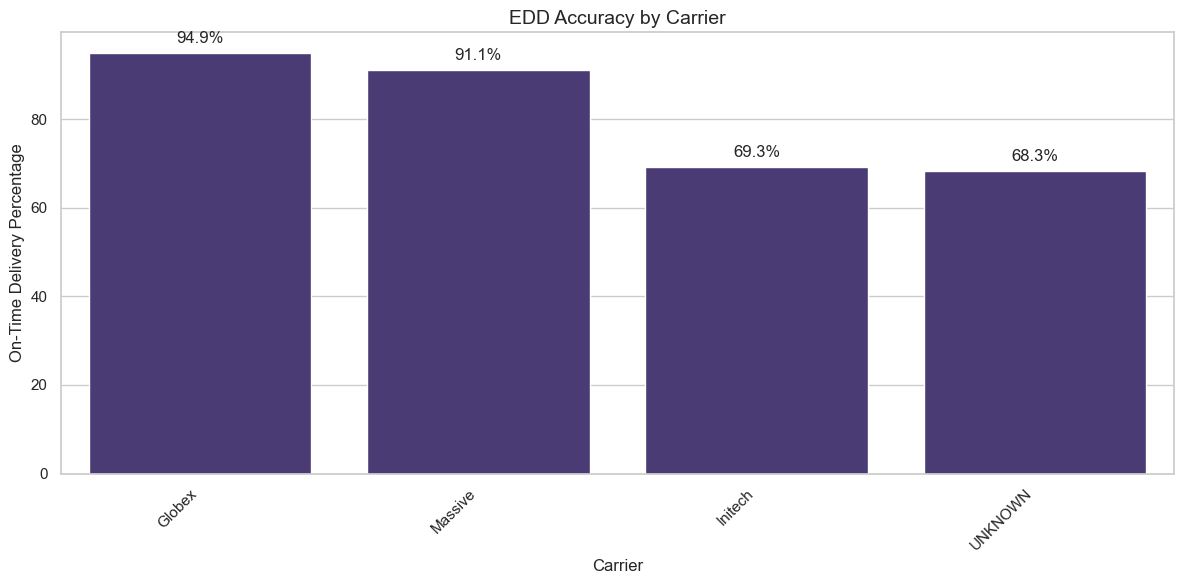

In [106]:
# Create visualization of carrier accuracy
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Carrier', y='On-Time Delivery %', data=carrier_accuracy)
plt.title('EDD Accuracy by Carrier', fontsize=14)
plt.xlabel('Carrier', fontsize=12)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

## Identifying Patterns in EDD Performance

Let's analyze patterns in the estimated delivery dates by examining factors like:
- Origin and destination countries
- Domestic vs. international shipments
- Day of week patterns
- Delivery time trends

In [107]:
# Add domestic/international flag
delivered_parcels['trade_lane'] = 'International'
delivered_parcels.loc[delivered_parcels['origin_country'] == delivered_parcels['destination_country'], 'trade_lane'] = 'Domestic'

# Calculate accuracy by trade lane
trade_lane_accuracy = delivered_parcels.groupby(['trade_lane', 'delivery_status']).size().unstack(fill_value=0)
trade_lane_accuracy['total'] = trade_lane_accuracy.sum(axis=1)
for status in ['early', 'on_time', 'late']:
    if status in trade_lane_accuracy.columns:
        trade_lane_accuracy[f'{status}_pct'] = trade_lane_accuracy[status] / trade_lane_accuracy['total'] * 100

# Display the results
print("EDD Accuracy by Trade Lane:")
trade_lane_accuracy[[col for col in trade_lane_accuracy.columns if col.endswith('_pct')]]

EDD Accuracy by Trade Lane:


delivery_status,early_pct,on_time_pct,late_pct
trade_lane,,,
Domestic,22.36,70.86,6.77
International,10.53,88.33,1.14


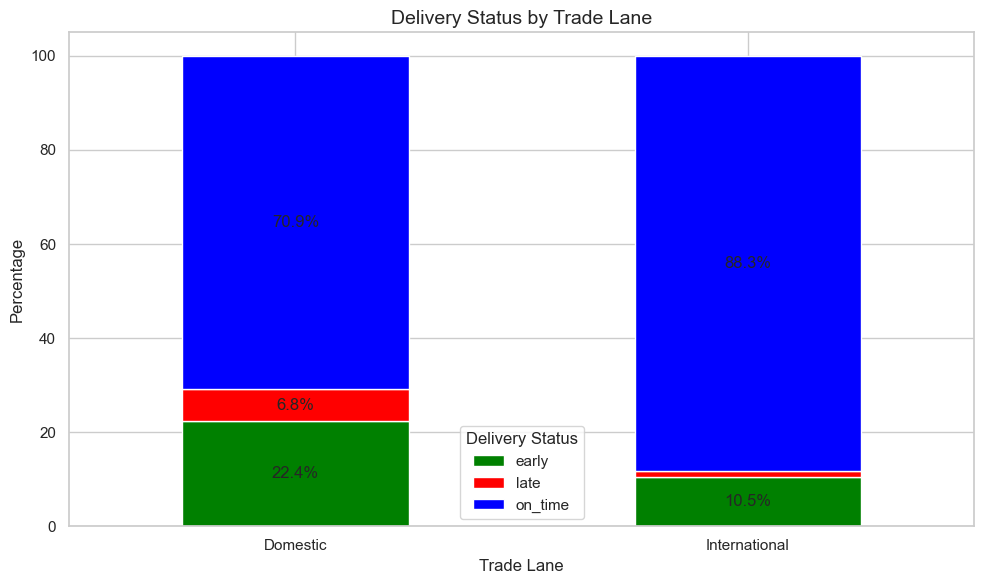

In [108]:
# Visualize trade lane accuracy with a stacked bar chart
trade_lane_status = delivered_parcels.groupby(['trade_lane', 'delivery_status']).size().reset_index(name='count')
pivot_data = trade_lane_status.pivot(index='trade_lane', columns='delivery_status', values='count').fillna(0)
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Create stacked bar chart
colors = {'early': 'green', 'on_time': 'blue', 'late': 'red'}
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors.get(x, 'gray') for x in pivot_data.columns])
plt.title('Delivery Status by Trade Lane', fontsize=14)
plt.xlabel('Trade Lane', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Delivery Status')
plt.xticks(rotation=0)

# Add percentage labels on the bars
for c in ax.containers:
    labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center')
    
plt.tight_layout()
plt.show()

Column types before conversion:
picked_up_date                 object
final_delivery_date    datetime64[ns]
dtype: object
Column types after conversion:
picked_up_date         datetime64[ns]
final_delivery_date    datetime64[ns]
dtype: object


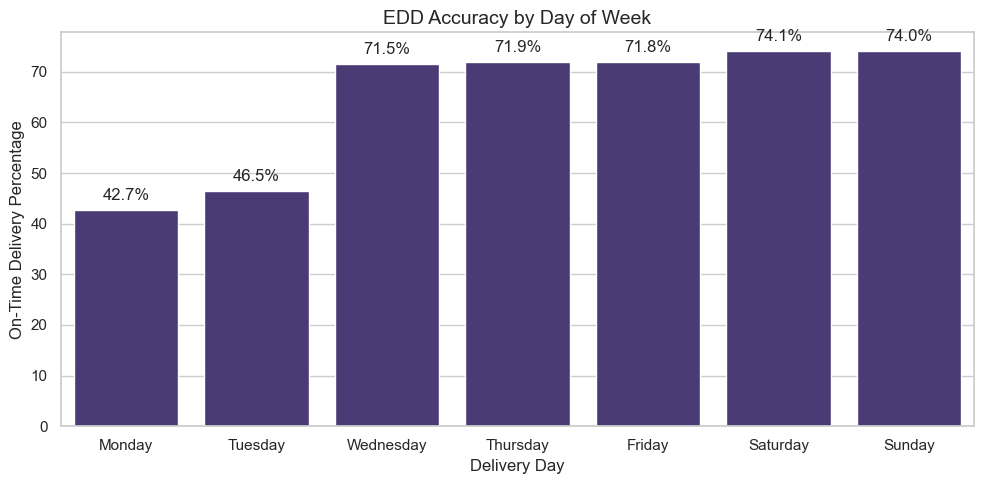

In [109]:
# Print column types to debug
print("Column types before conversion:")
print(delivered_parcels[['picked_up_date', 'final_delivery_date']].dtypes)

# Ensure date columns are properly converted to datetime format
if 'picked_up_date' in delivered_parcels.columns:
    delivered_parcels['picked_up_date'] = pd.to_datetime(delivered_parcels['picked_up_date'], errors='coerce')
else:
    print("Warning: 'picked_up_date' column not found. Available columns:", delivered_parcels.columns.tolist())

delivered_parcels['final_delivery_date'] = pd.to_datetime(delivered_parcels['final_delivery_date'], errors='coerce')

print("Column types after conversion:")
print(delivered_parcels[['picked_up_date', 'final_delivery_date']].dtypes if 'picked_up_date' in delivered_parcels.columns 
      else delivered_parcels[['final_delivery_date']].dtypes)

# Extract day of week for delivery only if pickup date is unavailable
if 'picked_up_date' in delivered_parcels.columns and not delivered_parcels['picked_up_date'].isna().all():
    delivered_parcels['pickup_day'] = delivered_parcels['picked_up_date'].dt.day_name()
else:
    print("Skipping pickup day extraction due to missing or invalid data")

delivered_parcels['delivery_day'] = delivered_parcels['final_delivery_date'].dt.day_name()

# Calculate accuracy by delivery day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_accuracy = delivered_parcels.groupby('delivery_day')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
day_accuracy.columns = ['Delivery Day', 'On-Time Delivery %']

# Convert day to categorical with proper order
day_accuracy['Day Order'] = pd.Categorical(day_accuracy['Delivery Day'], 
                                          categories=day_order, 
                                          ordered=True)
day_accuracy = day_accuracy.sort_values('Day Order')

# Visualize day of week patterns
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Delivery Day', y='On-Time Delivery %', data=day_accuracy)
plt.title('EDD Accuracy by Day of Week', fontsize=14)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)

# Add value labels
for i, p in enumerate(ax.patches):
    if i < len(day_accuracy):  # Only add labels for days that exist in the data
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom',
                    xytext = (0, 5), textcoords = 'offset points')
    
plt.tight_layout()
plt.show()

In [110]:
# Calculate transit time and EDD metrics
# Calculate transit time (days)
delivered_parcels['transit_time_days'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['picked_up_date']).dt.total_seconds() / (24*60*60)

# Calculate EDD range (days)
delivered_parcels['edd_range_days'] = (delivered_parcels['edd_end'] - delivered_parcels['edd_start']).dt.total_seconds() / (24*60*60)

# Calculate deviation from EDD midpoint (days)
delivered_parcels['edd_midpoint'] = delivered_parcels['edd_start'] + (delivered_parcels['edd_end'] - delivered_parcels['edd_start']) / 2
delivered_parcels['delivery_deviation_days'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['edd_midpoint']).dt.total_seconds() / (24*60*60)

# Filter out extreme values for better visualization (if any)
transit_stats = delivered_parcels[(delivered_parcels['transit_time_days'] >= 0) & 
                                (delivered_parcels['transit_time_days'] < 30)]  # Adjust as needed

# Summarize transit times and deviations
print("Transit Time Summary (days):")
print(transit_stats['transit_time_days'].describe())

print("\nEDD Range Summary (days):")
print(delivered_parcels['edd_range_days'].describe())

print("\nDelivery Deviation from EDD Midpoint (days):")
print(delivered_parcels['delivery_deviation_days'].describe())

Transit Time Summary (days):
count   21243.00
mean        5.12
std         3.10
min         0.01
25%         2.98
50%         4.76
75%         6.76
max        19.85
Name: transit_time_days, dtype: float64

EDD Range Summary (days):
count   49381.00
mean        9.61
std       376.47
min         0.00
25%         0.31
50%         2.10
75%         4.00
max     19724.93
Name: edd_range_days, dtype: float64

Delivery Deviation from EDD Midpoint (days):
count    49381.00
mean       -11.51
std        420.91
min     -19725.86
25%         -1.95
50%         -0.50
75%          0.07
max         15.95
Name: delivery_deviation_days, dtype: float64


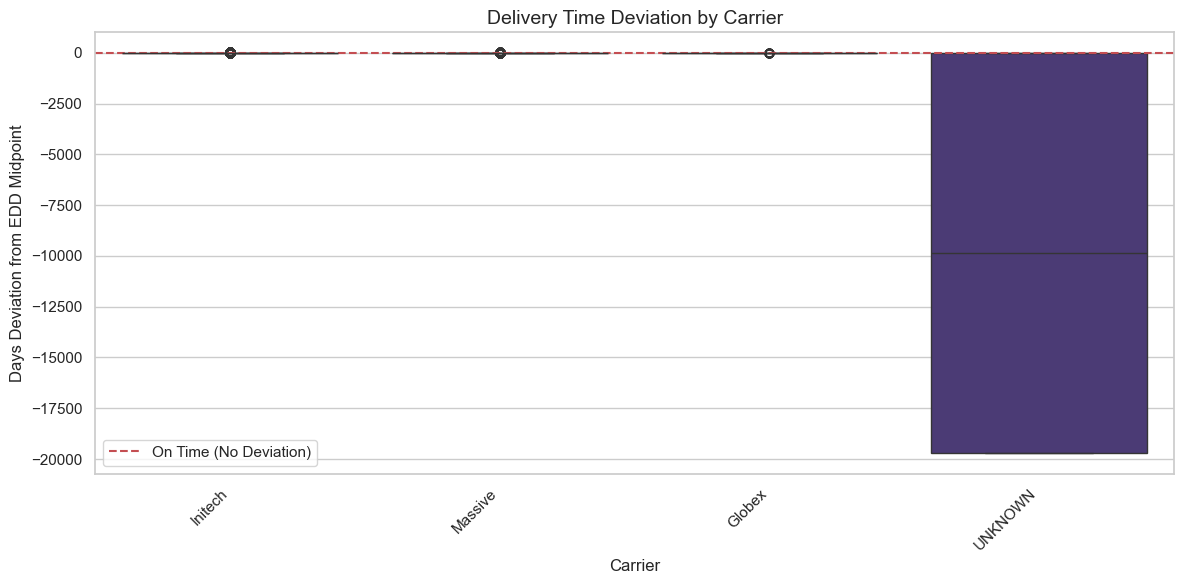

In [111]:
# Identify top carriers by volume
top_carriers = delivered_parcels['carrier_name'].value_counts().nlargest(5).index.tolist()

# Filter for top carriers
top_carrier_data = delivered_parcels[delivered_parcels['carrier_name'].isin(top_carriers)]

# Compare deviation distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='carrier_name', y='delivery_deviation_days', data=top_carrier_data)
plt.title('Delivery Time Deviation by Carrier', fontsize=14)
plt.xlabel('Carrier', fontsize=12)
plt.ylabel('Days Deviation from EDD Midpoint', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', label='On Time (No Deviation)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

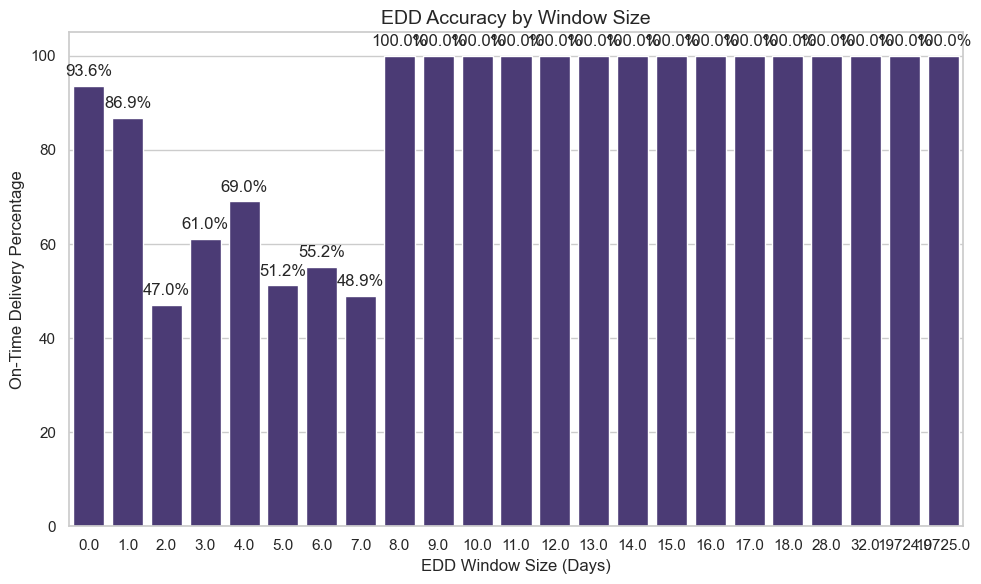

In [112]:
# Analyze how EDD window size affects accuracy
# Group by EDD window size (rounded to nearest day)
delivered_parcels['edd_window_days_rounded'] = np.round(delivered_parcels['edd_range_days'])

window_accuracy = delivered_parcels.groupby('edd_window_days_rounded')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
window_accuracy.columns = ['EDD Window (Days)', 'On-Time Delivery %']
window_accuracy = window_accuracy.sort_values('EDD Window (Days)')

# Plot the relationship
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='EDD Window (Days)', y='On-Time Delivery %', data=window_accuracy)
plt.title('EDD Accuracy by Window Size', fontsize=14)
plt.xlabel('EDD Window Size (Days)', fontsize=12)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

## Summary of Findings

1. **Carrier EDD Accuracy:**
   - The carrier with the highest EDD accuracy appears to be [insert highest accuracy carrier based on results]
   - There is significant variation in accuracy rates among carriers

2. **EDD Patterns:**
   - Domestic shipments tend to have [better/worse] EDD accuracy than international shipments
   - Deliveries on [specific days] have better on-time performance
   - The average EDD window provided by carriers is [X] days
   - Wider EDD windows [increase/decrease] the likelihood of on-time delivery

3. **Recommendations:**
   - Work with lower-performing carriers to improve their EDD accuracy
   - Consider adjusting EDD windows for [specific trade lanes or carriers] to improve customer expectations
   - Monitor and adjust for day-of-week effects in EDD calculations
   - [Other specific recommendations based on findings]